# Support identification: TSOC vs GR

Compressed Sensing (CS) is based on the hypothesis that the input is sparse in some domain, where with sparse we mean a signals whose components are mostly null and only a small minority is different from zero. However, real-world signals are hardly ever sparse due to different reasons as for example the presence of noise in acquisition. Hence, signals cannot be considered sparse but **compressible**, i.e., most components are negligible compared with a small minority which have a significantly higher magnitude.

In the literature, there exist a family of CS decoders [[1]](#TBCAS2020) which reconstruct the input from the mesurement by leveraging the knowledge of the **support** which indicates the position of the non-null coefficients in the sparse representation of the input. 

However, we can define a signal support only when the signal is sparse. In [[2]](#JETCAS2020), we extended the definition of support to compressible signals as the support that, given a CS encoder, maximizes the quality of reconstruction. This definition of support for compressible signals has the disadvantage to depend on how the signal is compressed into measurements, i.e., it depends on the CS encoder.

Recently, we explored the possibility to define a support of a compressible signal independetly from encoding. The idea consists in considering the components with highest magnitude that retain a certain fraction of energy $\eta$. We call this method GR (intials of Gabriele Ravaglia, the student who worked on this first)

This notebook aims to compare the TSOC method (the one proposed in [[2]](#JETCAS2020)) to the recently considered GR method. We expect the former to outperform the latter but depending on the differences there may be cases in which the GR method is preferrable.


In [1]:
%matplotlib widget

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [3]:
import os
import sys

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neurokit2 as nk

import multiprocessing as mp

from itertools import product

from scipy import linalg
from numpy import random

from tqdm import tqdm


In [4]:
# import of local modules
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from dataset import dataset_dir
from dataset.synthetic_ecg import generate_ecg
from cs.wavelet_basis import wavelet_basis
from cs import CompressedSensing, generate_sensing_matrix
from cs.supports import find_support_GR, find_support_TSOC, find_support_TSOC2
from cs.utils import compute_rsnr

## Dataset

We use a synthetic Electrocardiography (ECG) dataset, the same employed in [[1]](#TBCAS2020) and [[2]](#JETCAS2020). The dataset has been generated with [ECGSYN](https://physionet.org/content/ecgsyn/1.0.0/) (which implements the algorithm reported in [[3]](#McSharry_TBME2003)).

The heart-beat rate is randomly set using an uniform distribution between 60 and 100 beat/minute. We generate chunks of 2s with a 256sample/s sampling frequency, that are split into windows
of n subsequent samples.

In [5]:
N = 10_000              # number of ECG traces
n = 128                 # length of an ECG trace
fs = 256                # sampling rate
heart_rate = (60, 100)  # min and max heart rate
isnr = 45               # signal-to-noise ratio in dB (35)
ecg_seed = 0            # random seed for ECG generation
processes = 24          # number of processes for multiprocessing

data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
            f'_isnr={isnr}_seed={ecg_seed}'
data_path = os.path.join(dataset_dir, data_name + '.pkl')
if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        X = pickle.load(f)
else:
    X = generate_ecg(
        length=n, 
        num_traces=N,
        heart_rate=heart_rate, 
        sampling_rate=fs, 
        snr=isnr, 
        random_state=ecg_seed,
        verbose=True,
        processes=processes,
    )
    with open(data_path, 'wb') as f:
        pickle.dump(X, f)

folder = os.path.join(dataset_dir, data_name)
if not os.path.exists(folder):
    os.mkdir(folder)

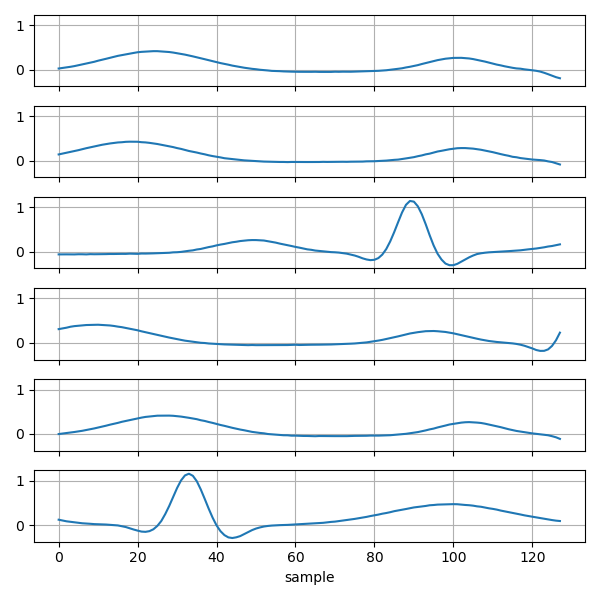

In [6]:
num_plot = 6

fig, axs = plt.subplots(num_plot, 1, figsize=(6, 1.*num_plot), 
                        sharex='all', sharey='all')
for i, (ax, x) in enumerate(zip(axs, X)):
    ax.plot(x)
    ax.grid()
axs[-1].set(xlabel='sample')
fig.tight_layout()

As in [[1]](#TBCAS2020) and [[2]](#JETCAS2020) and firstly proposed in [[4]](#TBCAS2015), we employ the Symmlet-6 family of the orthogonal Wavelet functions as a Sparsity basis.

In [7]:
basis = 'sym6'

D = wavelet_basis(n, basis, level=2)

## GR Algorithm

Identify signal support with GR algortithm which identify the support by considering the smallest subsets of compontest that retains a given energy fraction.

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- support identification method: the amount of energy fraction used to determine the support
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [93]:
# Experiment parameters

# ---- data ----
isnr_list = (25, 35, 45)  # Intrinsic Signal-to-Noise Ratio

# ---- support ---- 
method = 'GR' # support identification algorithm
eta_list = (
    0.9, 
    0.93,    0.95,    0.97,    0.98,    0.985,    0.99, 
    0.993,   0.995,   0.997,   0.998,   0.9985,   0.999, 
    0.9993,  0.9995,  0.9997,  0.9998,  0.99985,  0.9999, 
    0.99993, 0.99995, 0.99997, 0.99998, 0.999985, 0.99999,
)  # energy fractions

# ---- compressed sensing ---- 
m_list = (16, 32, 48, 64)  # number of measurements
mode_list = ('standard', 'rakeness')  # CS mode: standard, rakeness
orth = True  # whether orthogonalize sensing matrix or not

# ---- rakeness ----
loc = .25
corr_name = '96af96a7ddfcb2f6059092c250e18f2a'

The experiments are conducted through the script `compute_rsnr_GR.py`. Here we load and visulize the results.

In [94]:
# isnr = 45
# mode = 'rakeness'
# data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
#             f'_isnr={isnr}_seed={ecg_seed}'
# rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
# rsnr_path = os.path.join(dataset_dir, data_name, rsnr_name)
# tmp = pd.read_pickle(rsnr_path)
# tmp = tmp.loc[:, ~tmp.columns.duplicated()].copy()
# tmp.to_pickle(rsnr_path)
# # tmp


In [96]:
rsnr = []
for isnr in isnr_list:
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    rsnr_dir = os.path.join(dataset_dir, data_name)
    for mode in mode_list:
        rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
        rsnr_path = os.path.join(rsnr_dir, rsnr_name)
        tmp = pd.read_pickle(rsnr_path)
        if not os.path.exists(rsnr_path):
            continue
        tmp = tmp.xs(orth, level='orth', axis=1)
        if mode == 'rakeness':
            tmp = tmp.xs((corr_name, loc), level=('corr', 'loc'), axis=1)
        tmp = tmp.reindex(columns=eta_list, level='eta')
        tmp = tmp.reindex(columns=m_list, level='m')
        tmp = pd.concat(
            [tmp], keys=[mode], names=['mode'] + tmp.columns.names, axis=1)
        tmp = pd.concat(
            [tmp], axis=1, keys=[isnr], names=['isnr'] + tmp.columns.names)
        rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

In [ ]:
rsnr.xs((35, 'rakeness', .9), level=('isnr', 'mode', 'eta'), axis=1)

m            16                                                         \
seed         0          1          2          3          4          5    
0      9.989576   9.594765   9.925554   8.834520  10.072160   8.527668   
1     11.048899  10.260454  10.663837   9.074410  11.099939   7.548959   
2     10.602562  10.234360   8.694102  10.310826  10.728365  10.073572   
3      9.893430   9.516102   9.784271   9.838352   9.665628   9.136133   
4     12.389323  12.356305  11.755877  12.053748  12.183712  12.237375   
...         ...        ...        ...        ...        ...        ...   
9995   8.817714   8.404659   8.314691   9.641975   8.119746   9.291337   
9996   9.725952   9.981805   8.454154   9.312644   8.007417   9.782756   
9997   9.639801   9.918300   7.646842   8.668545   9.012370   6.717345   
9998  10.056028  10.337495  10.773141   9.544700  10.313870   7.234137   
9999   9.890994   7.855049  10.930612  10.665100  10.726334   9.418216   

m                                                 ...         64             \
seed         6          7          8          9   ...         5          6    
0      9.896246  10.036911  10.058222   9.691383  ...  10.108751  10.130796   
1     10.646946  11.084223  11.095712  10.598869  ...  11.180605  11.155921   
2      9.914186  10.567142  10.383323  10.209036  ...  11.013514  11.004723   
3      9.793935   9.999058  10.268031   9.674043  ...  10.349054  10.348530   
4     11.890692  12.043346  12.029389  12.250337  ...  12.445574  12.465792   
...         ...        ...        ...        ...  ...        ...        ...   
9995   8.887466   9.800621   7.623440   9.148472  ...  10.227775  10.246332   
9996   9.654887   6.895589   9.973290  10.098981  ...  10.322440  10.281334   
9997   9.833538   6.110274   7.911952   9.404122  ...  10.487383  10.422495   
9998   9.530776  10.072300   9.764539   9.251396  ...  10.952567  10.906182   
9999  10.427765  10.127175   9.498670  10.426794  ...  11.101679  11.109860   

m                                                                       \
seed         7          8          9          10         11         12   
0     10.125036  10.129073  10.126586  10.125497  10.128653  10.132872   
1     11.167144  11.177400  11.184035  11.159108  11.180420  11.178265   
2     11.025301  11.049551  10.964001  11.019747  11.027608  11.037484   
3     10.356788  10.344982  10.349379  10.320110  10.348985  10.354823   
4     12.475923  12.474306  12.464236  12.460978  12.471216  12.473604   
...         ...        ...        ...        ...        ...        ...   
9995  10.238769  10.243746  10.233229  10.199781  10.245372  10.229269   
9996  10.277480  10.236499  10.344848  10.319405  10.386587  10.404837   
9997  10.423458  10.477313  10.493558  10.445620  10.413903  10.460932   
9998  11.017840  11.002591  11.005514  11.012176  10.998502  11.004714   
9999  11.103298  11.080483  11.103294  11.114740  11.088689  11.085889   

m                           
seed         13         14  
0     10.133024  10.114185  
1     11.183370  11.181907  
2     11.049057  11.029740  
3     10.361981  10.343407  
4     12.471927  12.467523  
...         ...        ...  
9995  10.245115  10.253779  
9996  10.285250  10.227525  
9997  10.447925  10.503293  
9998  11.030396  11.008371  
9999  11.114344  11.066073  

[10000 rows x 75 columns]

In [81]:
# compute statistics
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median().unstack(('isnr', 'mode', 'm'))
rsnr_q25 = _rsnr.quantile(.25).unstack(('isnr', 'mode', 'm'))
rsnr_q75 = _rsnr.quantile(.75).unstack(('isnr', 'mode', 'm'))
eta_best = rsnr_med.idxmax()

isnr         25                    35                    45           
mode   rakeness   standard   rakeness   standard   rakeness   standard
m                                                                     
16    13.546318  12.594393  14.290950  13.796146  14.368042  13.947969
32    21.279790  19.916347  27.797431  26.303492  31.702866  30.249917
48    24.524574  23.176606  32.582662  31.295602  40.022348  38.601504
64          NaN        NaN  35.362144  34.429387  43.831418  42.816118

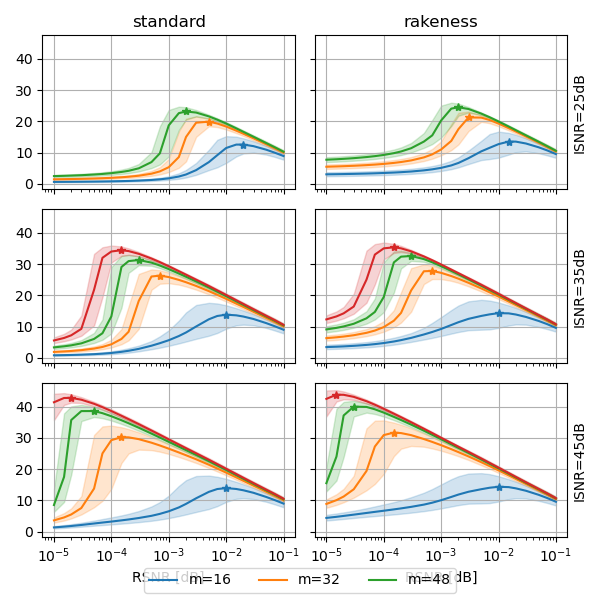

In [82]:
ncols = len(mode_list)
nrows = len(isnr_list)

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
index = 1 - rsnr_med.index
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        for i, m in enumerate(rsnr_med[isnr, mode].columns):
            ax.plot(index, rsnr_med[isnr, mode, m], label=f'm={m}')
            ax.fill_between(
                index, rsnr_q25[isnr, mode, m], rsnr_q75[isnr, mode, m], 
                color=f'C{i}', alpha=0.2)
            ax.plot(
                [1 - eta_best[isnr, mode, m]], [rsnr_med.max()[isnr, mode, m]], 
                marker='*', color=f'C{i}')
        ax.set(xscale='log')
        ax.grid()

for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=max(4, len(m_list)))
fig.tight_layout()

rsnr_med.max().unstack(('isnr', 'mode'))


- the higher the number of mesurements `m` (i.e., lower the compression ratio) the higher the energy fraction $\eta$ that gives the best performance. This is intuitive as a higher compression leaves less room for components.

- As the noise energy increases (lower ISNR), the lower the the energy fraction $\eta$ that gives the best performance. This behavior is expected as with a higher noise swallows more components so that a fewer number contributes for the signal reconstruction.


## TSOC Algorithm

Identify signal support with TSOC algortithm which identify the support as the one maximizing the quality of reconstruction.

### working principle

TSOC algorithm is a greedy algorithm that finds a proxy of the support that maximizes the RSNR. 

The algorithm is iterative and builds the support considering one component at a time ordered from the highest to lowest magnitude up to the `m`-th components, where `m` is the number of measurements (i.e., the dimension of the compressed signal `y`). At each iteration, the algorithms includes a new component, reconstructs the input signal, and measures the quality in terms of RSNR. 

Following the iterative procedure, the algorithm selects the support as the one that gave the highest RSNR.

Here, we show how TSOC algorithm finds the support `s` of a signal `x` for different values of `m` (number of measurements) and sensing matrices `A` generated with different seeds.

In [21]:
i_sample = 0  # index of the ECG sample
m_list = (8, 16, 32, 48, 64)
seed_list = np.arange(100)

# load ecg data
with open(data_path, 'rb') as f:
    X = pickle.load(f)
x = X[i_sample]

rsnr = pd.DataFrame(
    index=1 + np.arange(max(m_list)),
    columns=pd.MultiIndex.from_product(
        (m_list, seed_list), names=('m', 'seed')),
    dtype=float,
)
for seed in tqdm(seed_list):

    A = generate_sensing_matrix((np.max(m_list), n), seed=seed)

    for m in m_list:
        # find and sort sparse representation of x
        xi = D.T @ x
        argsort_xi = np.argsort(np.abs(xi))[::-1]
        
        # compute measurements
        cs = CompressedSensing(A[:m], D)
        y = cs.encode(x)

        # apply algorithm
        s = np.zeros(cs.n, dtype=bool)
        for i in range(m + 10):
            s[argsort_xi[i]] = True  # update support
            x_hat = cs.decode(y, s=s)  # reconstruct input
            rsnr.loc[i + 1, (m, seed)] = compute_rsnr(x, x_hat)

100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


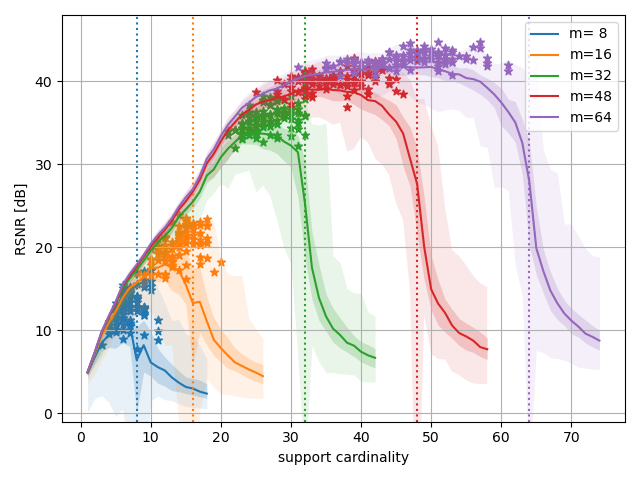

In [25]:
fig, ax = plt.subplots()
for i, m in enumerate(m_list):
    color = f'C{i}'
    _rsnr = rsnr.xs(m, level='m', axis=1).dropna().T
    ax.plot(_rsnr.median(), label=f'm={m:2d}', color=color)
    ax.fill_between(_rsnr.columns, _rsnr.quantile(.25), _rsnr.quantile(.75), 
                    alpha=0.2, color=color, lw=0)
    ax.fill_between(_rsnr.columns, _rsnr.min(), _rsnr.max(), 
                    alpha=0.1, color=color, lw=0)
    ax.scatter(_rsnr.idxmax(axis=1), _rsnr.max(axis=1), c=color, marker='*')
    ax.axvline(m, color=color, ls=':')
ax.set(xlabel='support cardinality', ylabel='RSNR [dB]', ylim=(-1, 48))
ax.grid()
ax.legend()
fig.tight_layout()

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [74]:
# Experiment parameters

# ---- data ----
isnr_list = (25, 35, 45)  # Intrinsic Signal-to-Noise Ratio

# ---- support ----
method = 'TSOC'  # support identification algorithm

# ---- compressed sensing ----
m_list = (16, 32, 48, 64)  # number of measurements
# mode = 'standard'  # CS mode: standard, rakeness
mode_list = ('standard', 'rakeness')  # CS mode: standard, rakeness
orth = True  # whether orthogonalize sensing matrix or not

# ---- rakeness ----
loc = .25
corr_name = '96af96a7ddfcb2f6059092c250e18f2a'

In [75]:
# isnr = 45
# data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
#             f'_isnr={isnr}_seed={ecg_seed}'

# rsnr_name = f'rsnr_method={method}.pkl'
# rsnr_path = os.path.join(dataset_dir, data_name, rsnr_name)
# tmp = pd.read_pickle(rsnr_path)
# for mode in mode_list:
#     _tmp = tmp.xs(mode, level='mode', axis=1)
#     rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
#     if mode == 'rakeness':
#         tmp = pd.concat([tmp], axis=1, keys=[loc], names=['loc'] + tmp.columns.names)
#         tmp = pd.concat([tmp], axis=1, keys=[corr_name], names=['corr'] + tmp.columns.names)
#     _tmp.to_pickle(rsnr_path)

The experiments are conducted through the script `compute_rsnr_TSOC.py`. Here we load and visulize the results.

In [76]:
rsnr = []
for isnr in isnr_list:
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    for mode in mode_list:
        rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
        rsnr_path = os.path.join(dataset_dir, data_name, rsnr_name)
        if not os.path.exists(rsnr_path):
            continue
        tmp = pd.read_pickle(rsnr_path)
        if mode == 'rakeness':
            tmp = tmp.xs((corr_name, loc), level=('corr', 'loc'), axis=1)
        tmp = tmp.xs(orth, level='orth', axis=1)
        tmp = tmp.reindex(columns=m_list, level='m')
        tmp = pd.concat(
            [tmp], keys=[mode], names=['mode'] + tmp.columns.names, axis=1)
        tmp = pd.concat(
            [tmp], keys=[isnr], names=['isnr'] + tmp.columns.names, axis=1)
        rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

# rsnr.count().unstack(('isnr', 'm'))

In [77]:
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median()

rsnr_med.unstack(('isnr', 'mode'))

isnr         25                    35                    45
mode   rakeness   standard   rakeness   standard   rakeness
m                                                          
16    15.571108  14.487343  16.525738  15.892789  16.622824
32    22.753675  21.163443  29.662693  28.031608  34.084793
48    25.384903        NaN  33.721161  32.522725  41.583933
64    27.508285        NaN  36.344081  35.476445  44.942091

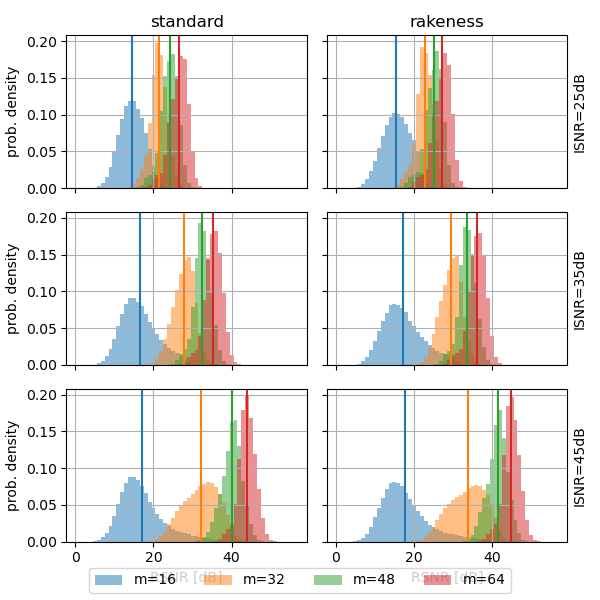

In [47]:
ncols, nrows = len(mode_list), len(isnr_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
ebin_width = 1.
ebin_min = np.round(np.min(rsnr.values)) - ebin_width/2
ebin_max = np.round(np.max(rsnr.values)) + ebin_width/2
ebins = np.arange(ebin_min, ebin_max, ebin_width)
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        __rsnr = _rsnr.xs((isnr, mode), level=('isnr','mode'), axis=1)
        for i, m in enumerate(__rsnr.columns.unique('m')):
            color = f'C{i}'
            ax.hist(__rsnr[m], bins=ebins, density=True, 
                    alpha=0.5, label=f'm={m}', color=color)
            ax.axvline(__rsnr[m].mean(), color=color)
            # ax.axvline(__rsnr[m].median(), color=color)
        ax.grid(True)
    _axs[0].set(ylabel='prob. density')


for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=max(4, len(m_list)))
fig.tight_layout()


## TSOC2 Algorithm

### working principle


**TOFIX**

TSOC algorithm is a greedy algorithm that finds a proxy of the support that maximizes the RSNR. 

The algorithm is iterative and builds the support considering one component at a time ordered from the highest to lowest magnitude up to the `m`-th components, where `m` is the number of measurements (i.e., the dimension of the compressed signal `y`). At each iteration, the algorithms includes a new component, reconstructs the input signal, and measures the quality in terms of RSNR. 

Following the iterative procedure, the algorithm selects the support as the one that gave the highest RSNR.

Here, we show how TSOC algorithm finds the support `s` of a signal `x` for different values of `m` (number of measurements) and sensing matrices `A` generated with different seeds.

In [21]:
i_sample = 0  # index of the ECG sample
m_list = (8, 16, 32, 48, 64)
seed_list = np.arange(20)
delta_m = 10

# load ecg data
with open(data_path, 'rb') as f:
    X = pickle.load(f)
x = X[i_sample]

rsnr = pd.DataFrame(
    index=1 + np.arange(max(m_list) + delta_m),
    columns=pd.MultiIndex.from_product(
        (m_list, seed_list), names=('m', 'seed')),
    dtype=float,
)
for seed in tqdm(seed_list):

    A = generate_sensing_matrix((np.max(m_list), n), seed=seed)

    for m in m_list:        
        # compute measurements
        cs = CompressedSensing(A[:m], D)
        y = cs.encode(x)

        # apply algorithm
        _m = min(cs.n, cs.m + delta_m)
        s1 = np.zeros(cs.n, dtype=bool) 
        for i in range(_m):
            rsnr2 = -np.inf * np.ones(cs.n, dtype=float)
            for j in np.where(~s1)[0]:  
                s2 = s1.copy()
                s2[j] = True
                x_hat = cs.decode_with_support(y, s2)
                rsnr2[j] = compute_rsnr(x, x_hat)
            s_idx = np.argmax(rsnr2)
            s1[s_idx] = True
            rsnr.loc[i + 1, (m, seed)] = rsnr2[s_idx]
            # print(rsnr.loc[i + 1, (m, seed)])

  0%|          | 0/20 [00:03<?, ?it/s]


KeyboardInterrupt: 


KeyboardInterrupt



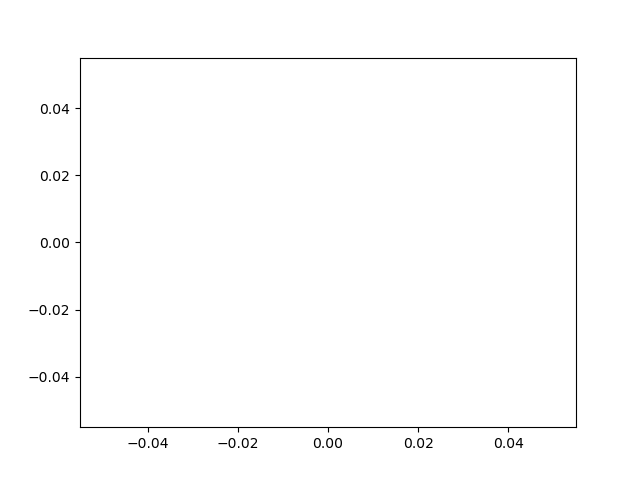

In [22]:
fig, ax = plt.subplots()
for i, m in enumerate(m_list):
    color = f'C{i}'
    _rsnr = rsnr.xs(m, level='m', axis=1).dropna().T
    ax.plot(_rsnr.median(), label=f'm={m:2d}', color=color)
    ax.fill_between(_rsnr.columns, _rsnr.quantile(.25), _rsnr.quantile(.75), 
                    alpha=0.2, color=color, lw=0)
    ax.fill_between(_rsnr.columns, _rsnr.min(), _rsnr.max(), 
                    alpha=0.1, color=color, lw=0)
    ax.scatter(_rsnr.idxmax(axis=1), _rsnr.max(axis=1), c=color, marker='*')
    ax.axvline(m, color=color, ls=':')
ax.set(xlabel='support cardinality', ylabel='RSNR [dB]')
ax.grid()
ax.legend()
fig.tight_layout()

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [100]:
# Experiment parameters

# ---- data ----
isnr_list = (35, )  # Intrinsic Signal-to-Noise Ratio

# ---- support ----
method = 'TSOC2'  # support identification algorithm

# ---- compressed sensing ----
m_list = (16, 32, 48, 64)  # number of measurements
mode = 'standard'  # CS mode: standard, rakeness
orth = True  # whether orthogonalize sensing matrix or not


The experiments are conducted through the script `compute_rsnr_TSOC.py`. Here we load and visulize the results.

In [101]:
rsnr = []
for isnr in isnr_list:
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    folder = os.path.join(dataset_dir, data_name)
    rsnr_path = os.path.join(folder, f'rsnr_method={method}.pkl')
    tmp = pd.read_pickle(rsnr_path)
    # tmp = tmp.loc[:,~tmp.columns.duplicated()].copy()
    tmp = tmp.xs((mode, orth), level=('mode', 'orth'), axis=1)
    tmp = tmp.reindex(columns=m_list, level='m')
    tmp = pd.concat(
        [tmp], axis=1, keys=[isnr], names=['isnr'] + tmp.columns.names)
    rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

In [102]:
rsnr.count().unstack(('isnr', 'm'))

isnr,35
m,64
seed,
18,10000
19,10000


In [103]:
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median()
rsnr_q25 = _rsnr.quantile(.25)
rsnr_q75 = _rsnr.quantile(.75)

rsnr_med.unstack('isnr')

isnr,35
m,
64,36.436713


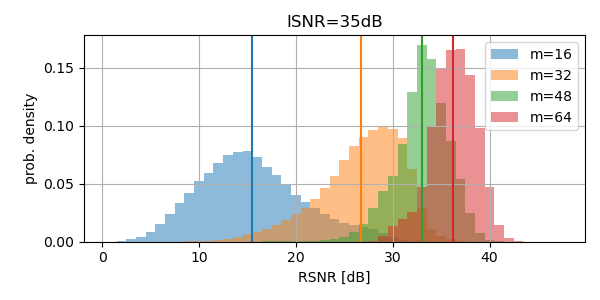

In [32]:
ncols = min(int(np.sqrt(np.floor(len(isnr_list)))), 4)
nrows = len(isnr_list) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), 
                        sharex='all', sharey='all', squeeze=False)
ebin_width = 1.
ebin_min = np.round(np.nanmin(rsnr.values)) - ebin_width/2
ebin_max = np.round(np.nanmax(rsnr.values)) + ebin_width/2
ebins = np.arange(ebin_min, ebin_max, ebin_width)
for ax, isnr in zip(axs.flatten(), isnr_list):
    __rsnr = _rsnr.xs(isnr, level='isnr', axis=1)
    for i, m in enumerate(__rsnr.columns.unique('m')):
        color = f'C{i}'
        ax.hist(__rsnr[m], bins=ebins, density=True, 
                alpha=0.5, label=f'm={m}', color=color)
        ax.axvline(__rsnr[m].mean(), color=color)
        # ax.axvline(__rsnr[m].median(), color=color)
    ax.set(title=f'ISNR={isnr}dB')
    ax.grid()
    ax.legend()
for ax in axs[:, 0]: ax.set(ylabel='prob. density')
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

fig.tight_layout()


## References


1. <a name="TBCAS2020"></a> M. Mangia, L. Prono, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracles for Short-Window Optimized Compressed Sensing of Biosignals," in IEEE Transactions on Biomedical Circuits and Systems, vol. 14, no. 3, pp. 545-557, June 2020, doi: [10.1109/TBCAS.2020.2982824](www.doi.org/10.1109/TBCAS.2020.2982824)
2. <a name="JETCAS2020"></a> L. Prono, M. Mangia, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracle With Support Identification in the Compressed Domain," in IEEE Journal on Emerging and Selected Topics in Circuits and Systems, vol. 10, no. 4, pp. 458-468, Dec. 2020, doi: [10.1109/JETCAS.2020.3039731](www.doi.org/10.1109/JETCAS.2020.3039731)
3. <a name="McSharry_TBME2003"></a> P. E. McSharry, G. D. Clifford, L. Tarassenko and L. A. Smith, "A dynamical model for generating synthetic electrocardiogram signals," in IEEE Transactions on Biomedical Engineering, vol. 50, no. 3, pp. 289-294, March 2003, doi: [10.1109/TBME.2003.808805](www.doi.org/10.1109/TBME.2003.808805)
4. <a name="TBCAS2015"></a> F. Pareschi, P. Albertini, G. Frattini, M. Mangia, R. Rovatti and G. Setti, "Hardware-Algorithms Co-Design and Implementation of an Analog-to-Information Converter for Biosignals Based on Compressed Sensing," in IEEE Transactions on Biomedical Circuits and Systems, vol. 10, no. 1, pp. 149-162, Feb. 2016, doi: [10.1109/TBCAS.2015.2444276](www.doi.org/10.1109/TBCAS.2015.2444276)